# Introduction

The following documents observations in the varying strengths and weaknesses of five machine learning algorithms; Decision Trees, K-Nearest Neighbors, Support Vector Machines, Boosting and Neural Networks. 

We compared the algorithms by testing their performance on classifying results for three unique datasets. By adjusting model hyperparameters, we were able to observe changes in performance using validation curves, learning curves, wall-clock time and loss curves where applicable. The analysis was performed in python 3.7 using the scikit-learn (sklearn) package, version 1.2.1.

Imports:

In [1]:
# data storage structures
import pandas as pd
import numpy as np

# scikit-learn preprocessing and modeling
from sklearn.datasets import fetch_openml
from sklearn.model_selection import validation_curve, learning_curve, ShuffleSplit, train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier

# plotting
import matplotlib.pyplot as plt

# timer
import time

# sqlite database storage for reproducibility
import sqlite3
import os

# random seed
np.random.seed(42)

# font size for plots
fs=22

# Get the data

Load datasets from openml with sklearn

- [bioresponse_data](https://www.openml.org/search?type=data&status=active&sort=nr_of_likes&qualities.NumberOfFeatures=between_1000_10000&id=4134): Binary classification of whether (1) or not (0) a molecule will elicit a biological response based on various molecular features. 3751 records, 1777 features, 2 classes. All numeric, none missing. Balanced (47%)
- [letter_data](https://www.openml.org/search?type=data&status=active&sort=nr_of_likes&qualities.NumberOfFeatures=gte_0&qualities.NumberOfInstances=between_10000_100000&qualities.NumberOfClasses=gte_2&id=6):  20000 records, 17 features, 26 classes. 16 numeric, 1 symbolic, none missing. Also well balanced (586/1600=0.03666/0.04166=0.879).

In [2]:
bio_data = fetch_openml(data_id = 4134, target_column=None, parser='auto')['data']
letter_data = fetch_openml(data_id = 6, target_column=None, parser='auto')['data']

# Preprocessing

These datasets are normalized and fairly clean, so the only processing we will cover before training our models training our models is:
- Train/test split with sklearn.model_selection.[train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
- Label encoding with sklearn.preprocessing.[OrdinalEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html)
- X/y split

In [3]:
# split into train/test sets
bio_train, bio_test = train_test_split(bio_data, test_size=0.2, random_state=42)
letter_train, letter_test = train_test_split(letter_data, test_size=0.2, random_state=42)

# encode label for letter data
ordinal_encoder = OrdinalEncoder(categories = [['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']])
letter_train['class'] = ordinal_encoder.fit_transform(letter_train[['class']])
letter_test['class'] = ordinal_encoder.fit_transform(letter_test[['class']])

# split x and y for test and train sets
bio_train_x, bio_train_y = bio_train.drop('target', axis=1), bio_train['target'].astype('int')
letter_train_x, letter_train_y = letter_train.drop('class', axis=1), letter_train['class']

bio_test_x, bio_test_y = bio_test.drop('target', axis=1), bio_test['target'].astype('int')
letter_test_x, letter_test_y = letter_test.drop('class', axis=1), letter_test['class']

## Performance Metrics

The use case of our bioresponse model would be in the pharmaceutical industry where molecular components are chosen for synthesis to form greater compounds, in which case an engineer would choose only components that elicit the firing, or positive, response. The primary concern in this workflow is false positives, so we measured the performance of the results using precision.

Our letter data is a multi-class dataset, so our goal was to look at the classifiers ability to differentiate between class labels while maintaining a reduction in error of all positive and negative outcomes. To achieve this goal, we looked at Matthew's Correlation Coefficient and Area Under the Reciever Operating Characteristic (ROC) Curve.

In [4]:
# precision scorer for binary bioresponse data
precision_scoring=['Precision', 'precision']

# matthew correlation and ROC AUC for multi-class letter data
mcc_scoring=['Matthew Correlation Coefficient', 'matthews_corrcoef']
rocauc_scoring=['ROC AUC', 'roc_auc_ovo']

## Cross Validation and Evaluation Curves

Below are a few helper functions for plotting our curves to analyze bias and variance

In [5]:
def plot_validation_curve(classifier, X, y, sql_table, conn, param_name, param_range, scoring, read_db=False, ax=None, cv=5, fs=22,lw=2):
    
    if not read_db:
        # timed cross-validation curve scores
        start = time.time()
        train_scores,test_scores = validation_curve(
            classifier, X, y, param_name=param_name[1], param_range=param_range,
            scoring=scoring[1], cv=cv)
        print(f'{param_name[0]} time: {time.time() - start}')
        
        # write to database
        pd.DataFrame(train_scores).to_sql(f'{sql_table}_{param_name[0]}_vc_train_scores', conn, if_exists="replace", index=False)
        pd.DataFrame(test_scores).to_sql(f'{sql_table}_{param_name[0]}_vc_test_scores', conn, if_exists="replace", index=False)
    
    if ax != None:
        # read from database
        train_scores = pd.read_sql_query(f"SELECT * FROM '{sql_table}_{param_name[0]}_vc_train_scores'", conn)
        test_scores = pd.read_sql_query(f"SELECT * FROM '{sql_table}_{param_name[0]}_vc_test_scores'", conn)
        
        # pass data to plotting function
        just_plot(train_scores, test_scores, param_name[0], param_range, ax=ax)

        # set x axis limit
        ax.set_xlim(param_range[0],param_range[-1])
        
    return [train_scores, test_scores]

In [6]:
def plot_learning_curve(classifier, X, y, sql_table, conn, scoring, read_db=False, ax=None, train_sizes_pct = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], jobs=4, fs=22, lw=2):

    if not read_db:
        # learning curve parameters
        common_params = {
            "X": X,
            "y": y,
            "train_sizes": train_sizes_pct,
            "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
            "scoring" : scoring[1],
            "n_jobs": jobs,
            "return_times": True
        }

        # timed learning curve scores
        start = time.time()
        train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(
            classifier, **common_params
        )
        print(f'Learning curve time: {time.time() - start}')

        # write to database
        pd.DataFrame(train_sizes).to_sql(f'{sql_table}_lc_train_sizes', conn, if_exists="replace", index=False)
        pd.DataFrame(train_scores).to_sql(f'{sql_table}_lc_train_scores', conn, if_exists="replace", index=False)
        pd.DataFrame(test_scores).to_sql(f'{sql_table}_lc_test_scores', conn, if_exists="replace", index=False)
        pd.DataFrame(fit_times).to_sql(f'{sql_table}_lc_fit_times', conn, if_exists="replace", index=False)
        pd.DataFrame(score_times).to_sql(f'{sql_table}_lc_score_times', conn, if_exists="replace", index=False)
        
    if ax != None:
        # read from database
        train_sizes = pd.read_sql_query(f"SELECT * FROM '{sql_table}_lc_train_sizes'", conn)
        train_scores = pd.read_sql_query(f"SELECT * FROM '{sql_table}_lc_train_scores'", conn)
        test_scores = pd.read_sql_query(f"SELECT * FROM '{sql_table}_lc_test_scores'", conn)
        fit_times = pd.read_sql_query(f"SELECT * FROM '{sql_table}_lc_fit_times'", conn)
        score_times = pd.read_sql_query(f"SELECT * FROM '{sql_table}_lc_score_times'", conn)

        # pass data to plotting function
        train_sizes=np.array(train_sizes).flatten()
        just_plot(train_scores, test_scores, 'Number of Samples (%)', train_sizes, ax=ax)

        # plot x axis parameters
        ax.set_xticks(train_sizes)
        ax.set_xticklabels([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
        ax.set_xlim(train_sizes[0],train_sizes[-1])

    
    return [train_sizes, train_scores, test_scores, fit_times, score_times]

In [7]:
def just_plot(train_scores, test_scores, param_name, param_range, ax, fs=22, lw=2):
    # calculate mean and standard deviation of multiple runs for train and test data
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    # plot training data
    ax.plot(param_range,train_mean, label=f'Training Set', color='darkorange',lw=lw)

    # plot training data standard deviation
    ax.fill_between(
        param_range,
        train_mean - train_std,
        train_mean + train_std,
        alpha=0.2,
        color="darkorange",
        lw=lw,
    )

    # x axis parameters
    ax.set_xlabel(param_name, fontsize=fs+2)
    if type(param_range[0]) != str:
        ax.set_xlim((min(param_range),max(param_range)))
        ax.set_xticks(list(ax.get_xticks())+[min(param_range)])

    # plot test/validation data
    ax.plot(param_range,test_mean, label=f'Validation Set', color='navy',lw=lw)

    # plot validation data standard deviation
    ax.fill_between(
        param_range,
        test_mean - test_std,
        test_mean + test_std,
        alpha=0.2,
        color="navy",
        lw=lw,
    )

    # additional plotting parameters
    ax.tick_params(axis='both', which='major', labelsize=fs)
    ax.grid()

### Database

For easy reproducibility, we'll save the model output to an SQLite database.

In [8]:
# open database
if not os.path.exists('db'):
    os.mkdir('db') 
conn = sqlite3.connect(os.path.join('db','compare_sklearn.db'))

# Decision Trees

Model created with sklearn.tree.[DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier).

In [49]:
# initial hyperparameter ranges
dt_md_name=['Max Depth', 'max_depth']
dt_md_range=range(2,21)

dt_msl_name = ['Minimum Samples Leaf', 'min_samples_leaf']
dt_msl_range = range(1,51)

dt_mss_name = ['Minimum Samples Split', 'min_samples_split']
dt_mss_range = range(2,31)

## Bioresponse Modeling

In [53]:
# initialize plot
plt.ioff()
fig, axs = plt.subplots(2, 3, constrained_layout=True)
fig.set_size_inches(20, 14)

# maximum depth
dt_bio_vc_depth = plot_validation_curve(DecisionTreeClassifier(random_state=42),
                                        bio_train_x, bio_train_y, sql_table='dt_bio', conn=conn, param_name=dt_md_name, param_range=dt_md_range, scoring=precision_scoring, read_db=True, ax=axs[0,0])

# minimum samples per leaf
dt_bio_vc_msl = plot_validation_curve(DecisionTreeClassifier(random_state=42), 
                                      bio_train_x, bio_train_y, sql_table='dt_bio', conn=conn, param_name=dt_msl_name, param_range=dt_msl_range, scoring=precision_scoring, read_db=True, ax=axs[1,0], cv=10)

# minimum samples per split
dt_bio_vc_mss = plot_validation_curve(DecisionTreeClassifier(random_state=42),
                                      bio_train_x, bio_train_y, sql_table='dt_bio', conn=conn, param_name=dt_mss_name, param_range=dt_mss_range, scoring=precision_scoring, read_db=True, ax=axs[0,1])
dt_bio_vc_mss = plot_validation_curve(DecisionTreeClassifier(random_state=42, max_depth=7, min_samples_leaf=29), 
                                      bio_train_x, bio_train_y, sql_table='dt_bio_2', conn=conn, param_name=dt_mss_name, param_range=dt_mss_range, scoring=precision_scoring, read_db=True, ax=axs[1,1])

# learning curves
dt_bio_lc = plot_learning_curve(DecisionTreeClassifier(random_state=42), 
                                bio_train_x, bio_train_y, sql_table='dt_bio', conn=conn, scoring=precision_scoring, read_db=True, ax=axs[0,2])
dt_bio_lc_tuned = plot_learning_curve(DecisionTreeClassifier(random_state=42, max_depth=7, min_samples_leaf=29), 
                                      bio_train_x, bio_train_y, sql_table='dt_bio_tuned', conn=conn, scoring=precision_scoring, read_db=True, ax = axs[1,2])

## Bioresponse Validation and Learning Curve Plots
Decision tree validation curves for bioresponse data while varying maximum tree depth (a), minimum number of samples needed to split a leaf (d) and minimum samples needed to split a branch (b and e). Plot (e) shows results after hyperparameter tuning. Learning curves show response before (c) and after (f) hyperparameter tuning.

In [54]:
# titles
fig.suptitle('Bioresponse Curves for Decision Tree Classifier',fontsize=fs+4)
axs[0,0].set_title('(a)',fontsize=fs+2)
axs[0,1].set_title('(b)',fontsize=fs+2)
axs[0,2].set_title('(c)',fontsize=fs+2)
axs[1,0].set_title('(d)',fontsize=fs+2)
axs[1,1].set_title('(e)',fontsize=fs+2)
axs[1,2].set_title('(f)',fontsize=fs+2)

# x axis limits
axs[0,1].set_xlabel(None)
axs[0,2].set_xlabel(None)

# y axis limits and labels
plt.setp(axs, ylim=[0.6,1.005])
axs[0,0].set_ylabel('Precision', fontsize=fs+2)
axs[1,0].set_ylabel('Precision', fontsize=fs+2)
axs[0,1].tick_params(labelleft=False, left=False)
axs[0,2].tick_params(labelleft=False, left=False)
axs[1,1].tick_params(labelleft=False, left=False)
axs[1,2].tick_params(labelleft=False, left=False)

# legend
axs[0,2].legend(loc="best", fontsize=fs)

### Analysis

Decision tree model complexity for bioresponse data increases with depth and number of splits. Validation precision increased until max depth 7 (a), and minimum samples per leaf of 39 (d). We saw a similar trend when varying the number of minimum samples per split (b), but after tuning our model's depth and samples per leaf, the minimum samples per split does not effect precision (e). This implies that the model will no longer change with additional forms of pruning.

The small margin between the learning curves after applying the same hyperparameter tuning (e) represents the reduction in variance, or overfitting, from the original learning curves (c), with increased performance which indicates that the model did not experience underfitting or increased bias as a trade-off. We also see a slight upwards trend in the validation line, indicating that variance may reduce further as we add additional samples.

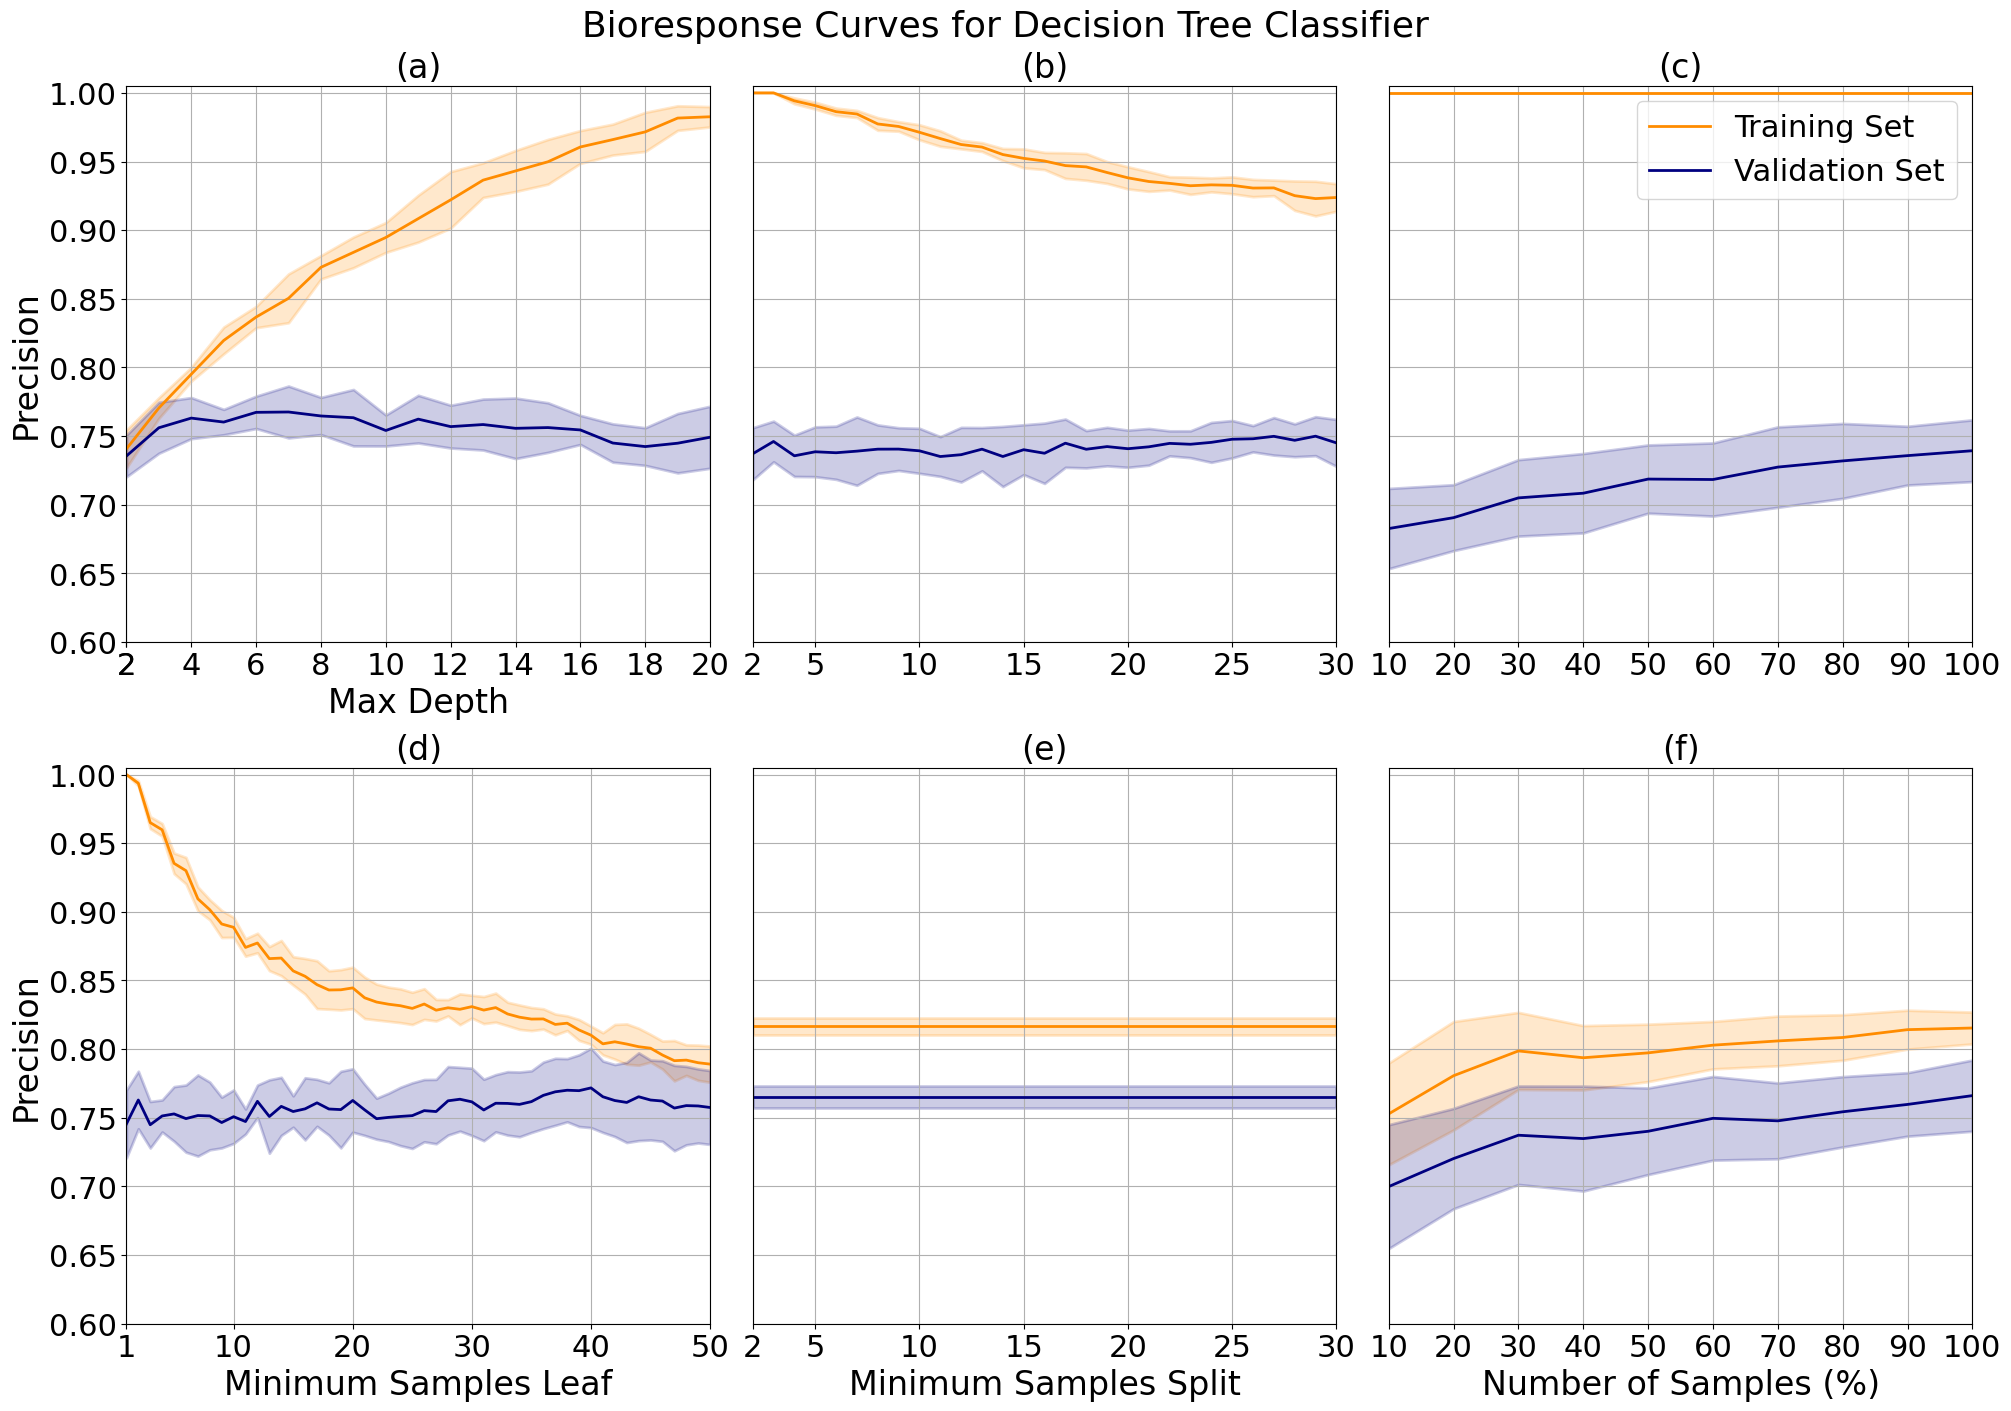

In [55]:
# plot or save
plt.show()
#plt.savefig('dt_bio.png',dpi=200)

## Letter Modeling

In [56]:
# initialize plot
plt.ioff()
fig, axs = plt.subplots(2, 3, constrained_layout=True)
fig.set_size_inches(20, 14)

# max depth
dt_md_range = range(2,31)
dt_letter_depth = plot_validation_curve(DecisionTreeClassifier(random_state=42),
                                           letter_train_x, letter_train_y, sql_table='dt_letter', conn=conn, param_name=dt_md_name, param_range=dt_md_range, scoring=mcc_scoring, read_db=True, ax=axs[0, 0])
dt_letter_depth_roc = plot_validation_curve(DecisionTreeClassifier(random_state=42),
                                               letter_train_x, letter_train_y, sql_table='dt_letter_roc', conn=conn, param_name=dt_md_name, param_range=dt_md_range, scoring=rocauc_scoring, read_db=True, ax=axs[1, 0])
# minimum samples per leaf
dt_msl_range=range(1,31)
dt_letter_msl = plot_validation_curve(DecisionTreeClassifier(random_state=42),
                                         letter_train_x, letter_train_y, sql_table='dt_letter', conn=conn, param_name=dt_msl_name, param_range=dt_msl_range, scoring=mcc_scoring, read_db=True, ax=axs[0, 1])
dt_letter_msl_roc = plot_validation_curve(DecisionTreeClassifier(random_state=42),
                                             letter_train_x, letter_train_y, sql_table='dt_letter_roc', conn=conn, param_name=dt_msl_name, param_range=dt_msl_range, scoring=rocauc_scoring, read_db=True, ax=axs[1, 1])

# learning curve
dt_letter_lc_tuned = plot_learning_curve(DecisionTreeClassifier(random_state=42, max_depth=15), 
                                         letter_train_x, letter_train_y, sql_table='dt_letter_tuned', conn=conn, scoring=mcc_scoring, read_db=True, ax=axs[0, 2])
dt_letter_lc_roc_tuned = plot_learning_curve(DecisionTreeClassifier(random_state=42, max_depth=15), 
                                             letter_train_x, letter_train_y, sql_table='dt_letter_roc_tuned', conn=conn, scoring=rocauc_scoring, read_db=True, ax=axs[1, 2])

## Letter Validation and Learning Curve Plots
Decision tree validation curves for letter data while varying maximum tree depth (a, d) and the minimum samples needed to split a leaf (b, e), and learning curves with applied hyperparameter tuning of maximum depth (c, f).

In [57]:
# titles
fig.suptitle('Letter Curves for Decision Tree Classifier',fontsize=fs+4)
axs[0,0].set_title('(a)',fontsize=fs+2)
axs[0,1].set_title('(b)',fontsize=fs+2)
axs[0,2].set_title('(c)',fontsize=fs+2)
axs[1,0].set_title('(d)',fontsize=fs+2)
axs[1,1].set_title('(e)',fontsize=fs+2)
axs[1,2].set_title('(f)',fontsize=fs+2)

# x labels
axs[0,0].set_xlabel(None)
axs[0,1].set_xlabel(None)
axs[0,2].set_xlabel(None)

# y limits and labels
axs[0,0].set_ylim((0.6,1.005))
axs[0,1].set_ylim((0.6,1.005))
axs[0,2].set_ylim((0.6,1.005))
axs[1,0].set_ylim((0.8,1.005))
axs[1,1].set_ylim((0.8,1.005))
axs[1,2].set_ylim((0.8,1.005))
axs[0,0].set_ylabel('Matthew Correlation Coefficient', fontsize=fs+2)
axs[1,0].set_ylabel('Area Under ROC Curve', fontsize=fs+2)
axs[0,0].tick_params(labelbottom=False, bottom=False)
axs[0,1].tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
axs[0,2].tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
axs[1,1].tick_params(labelleft=False, left=False)
axs[1,2].tick_params(labelleft=False, left=False)

# legend
axs[0,2].legend(loc="best", fontsize=fs)

### Analysis

Class distinction decreased after depth 12 due to overfitting (d), while correlation increased with depth until showing asymptotic behavior around depth 17 (a). We tuned our final model to the average of the two, 15, to leverage both. We left no limit on the minimum samples per leaf, as we observed that class distinction is only slightly improved as leaf minimum increases, but this comes at a significant cost to correlation (b and e). 

The tuned learning curve (c and f) have a relatively large margin (0.1) for correlation at the maximum number of samples showing that the model is overfit, but they trend towards convergence so we may see improved performance and a reduction in variance with more samples. This model shows extreme overfitting in class distinction, likely due to the multi-class label.

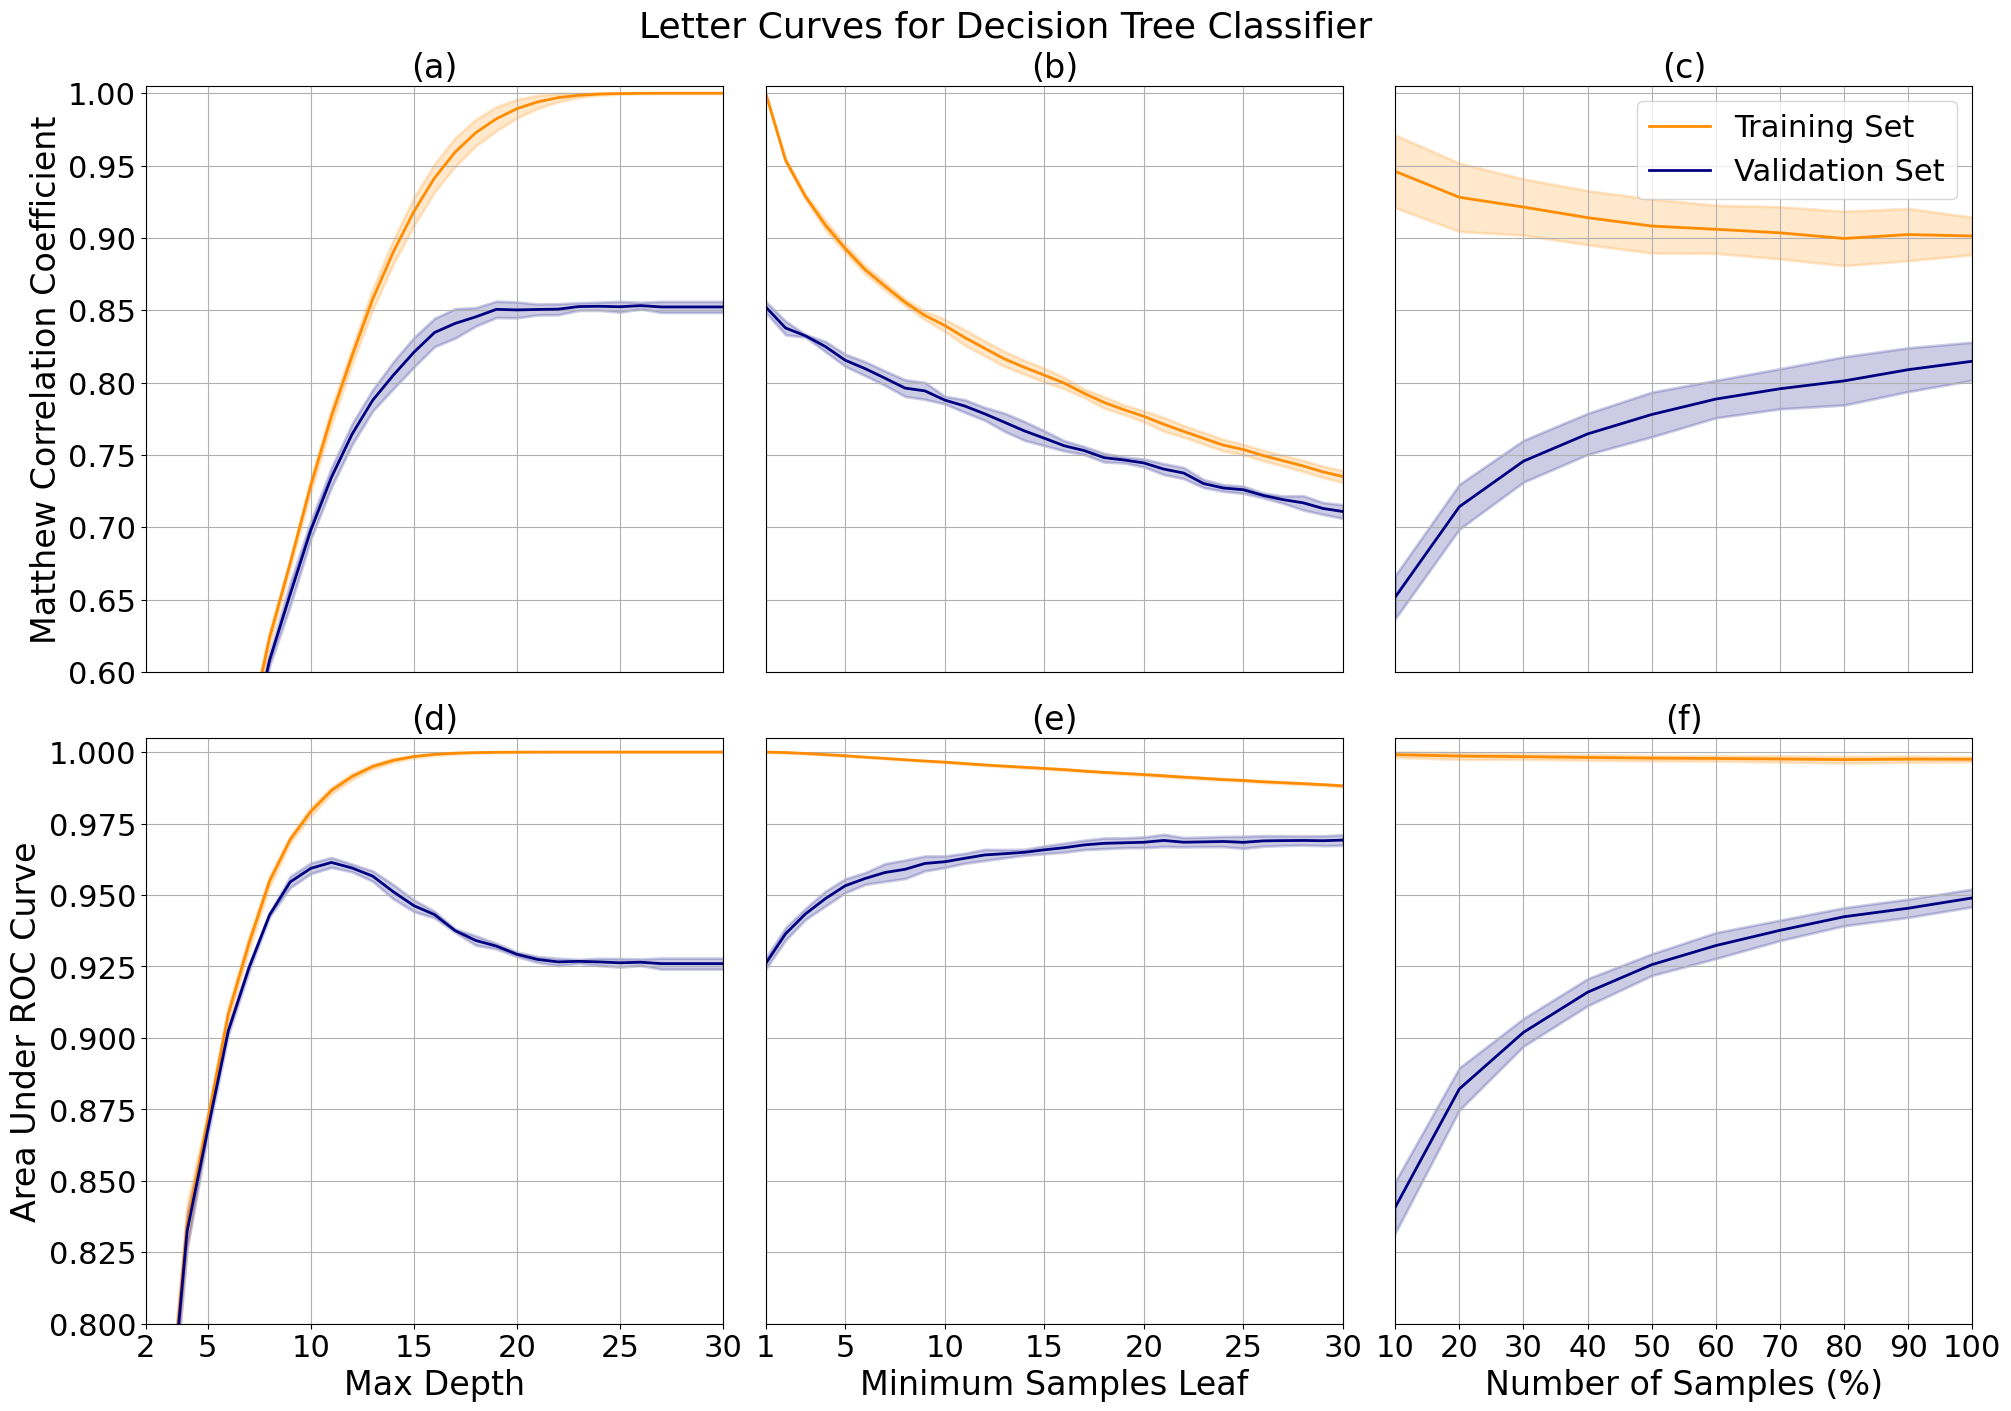

In [58]:
# plot or save
plt.show()
#plt.savefig('dt_letter.png',dpi=200)

# K-Nearest Neighbors

Model created with sklearn.neighbors.[KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html).

## Bioresponse Modeling

In [61]:
# initialize plot
plt.ioff()
fig, axs = plt.subplots(1, 4, constrained_layout=True)
fig.set_size_inches(22, 6)

# distance metric
knn_metric_name=['Distance Metric', 'metric']
knn_metric_range=['minkowski', 'cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan']
knn_metric_range_labels=['mink', 'cb', 'cos', 'euc', 'l1', 'l2', 'man']
knn_bio_metric = plot_validation_curve(KNeighborsClassifier(), bio_train_x, bio_train_y, sql_table='knn_bio', conn=conn, param_name=knn_metric_name, param_range=knn_metric_range, scoring=precision_scoring, read_db=True, ax=axs[0])

# number of neighbors
knn_nn_name=['Number of Neighbors', 'n_neighbors']
knn_nn_range=range(1,11)
knn_bio_nn = plot_validation_curve(KNeighborsClassifier(), bio_train_x, bio_train_y, sql_table='knn_bio', conn=conn, param_name=knn_nn_name, param_range=knn_nn_range, scoring=precision_scoring, read_db=True, ax=axs[1])

# learning curves
knn_bio_lc = plot_learning_curve(KNeighborsClassifier(n_neighbors=4, metric='cityblock'),
                                 bio_train_x, bio_train_y, sql_table='knn_bio', conn=conn, scoring=precision_scoring, read_db=True, ax=axs[2])
knn_bio_lc_tuned = plot_learning_curve(KNeighborsClassifier(n_neighbors=6, metric='cityblock'),
                                       bio_train_x, bio_train_y, sql_table='knn_bio_tuned', conn=conn, scoring=precision_scoring, read_db=True, ax=axs[3])

## Bioresponse Validation and Learning Curve Plots

K-nearest neighbors validation curves for bioresponse data while varying distance metric (a) and number of neighbors (b), and learning curves tuned to 4 (c) and (d) 6 neighbors.

In [62]:
# title and subplot titles
fig.suptitle('Bioresponse Curves for K-Nearest Neighbors Classifier',fontsize=fs+4)
axs[0].set_title('(a)',fontsize=fs+2)
axs[1].set_title('(b)',fontsize=fs+2)
axs[2].set_title('(c)',fontsize=fs+2)
axs[3].set_title('(d)',fontsize=fs+2)

# x limits and labels
axs[0].set_xticks([0,1,2,3,4,5,6])
axs[0].set_xticklabels(knn_metric_range_labels)
axs[2].set_xticks([240,  480,  960, 1440, 1920, 2400])
axs[2].set_xlim(240, 2400)
axs[3].set_xticks([240,  480,  960, 1440, 1920, 2400])
axs[3].set_xlim(240, 2400)

# y limits and labels
plt.setp(axs, ylim=[0.6,1.005])
axs[0].set_ylabel('Precision', fontsize=fs+2)
axs[1].tick_params(labelleft=False, left=False)
axs[2].tick_params(labelleft=False, left=False)
axs[3].tick_params(labelleft=False, left=False)

# legend
axs[3].legend(loc="best", fontsize=fs)

### Analysis

We saw minimal changes in performance between distance metrics (a) but chose to tune our final model to city block distance, which corresponds to Manhattan distance, which had slightly higher precision. The number of neighbors plot (b) shows us that the precision is greater on the even numbers of neighbors, which is atypical of this model where an even number of numbers for comparison often leads to a tie in samples at the decision boundary. 

We observed a decrease in overfitting from 4 (c) to 6 (d) neighbors as the margin between the training and validation set grew smaller with a minimal decrease in performance. We also observed an uptick in the rate of increase of validation precision between 90 and 100 samples, which when combined with the asymptotic behavior of the training precision indicates that the performance and fit of the model may continue to improve with more samples.

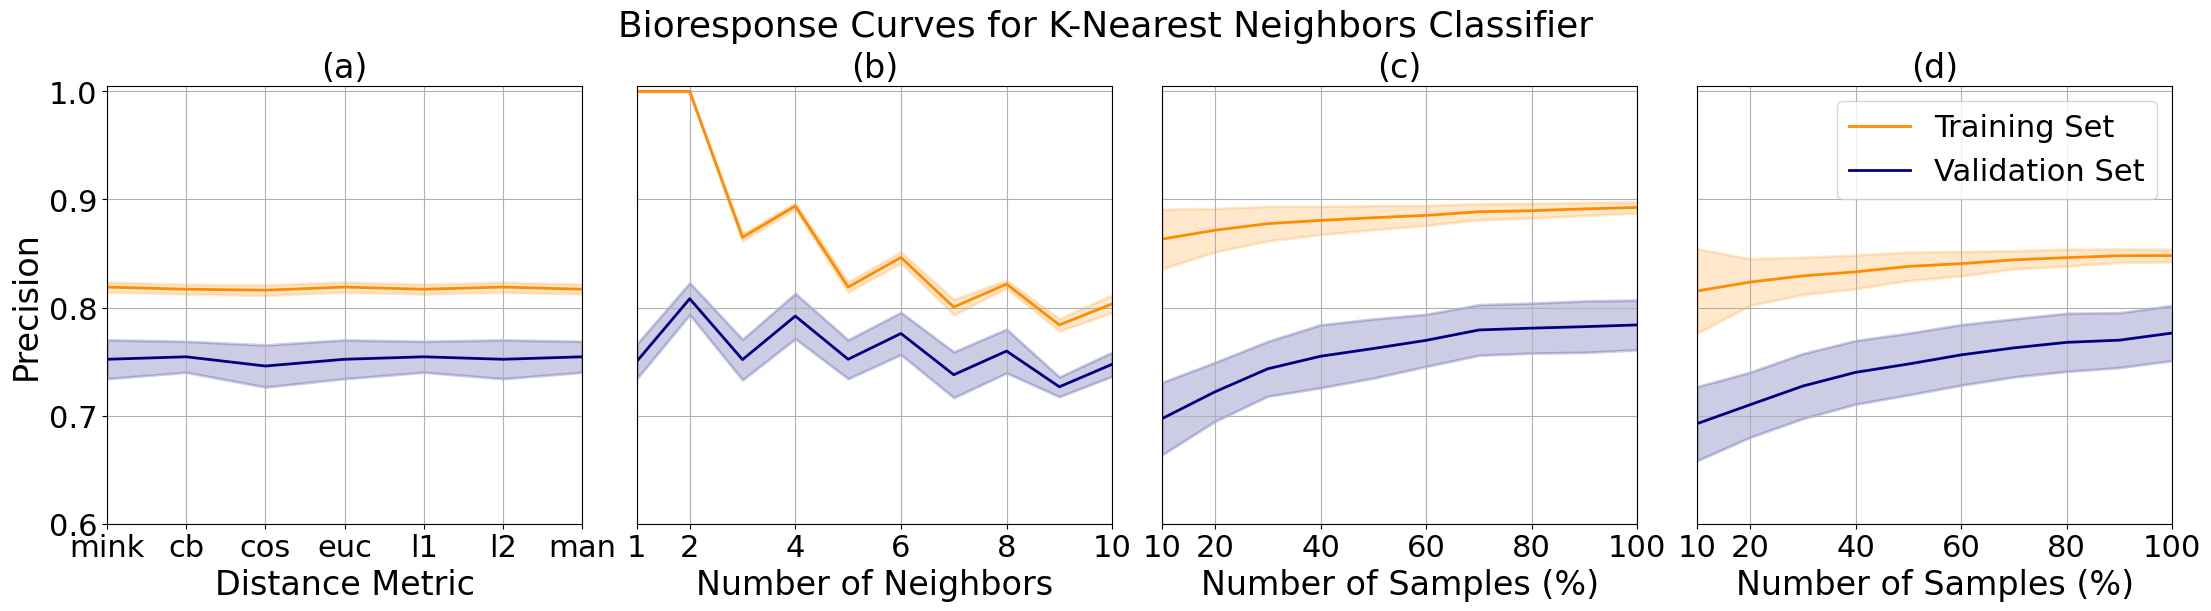

In [63]:
# plot or save
plt.show()
#plt.savefig('knn_bio.png',dpi=200)

##  Letter Validation and Learning Curve Modeling

In [39]:
# initialize plot
plt.ioff()
fig, axs = plt.subplots(2, 4, constrained_layout=True)
fig.set_size_inches(20,14)

# number of neighbors
knn_letter_nn = plot_validation_curve(KNeighborsClassifier(), letter_train_x, letter_train_y, sql_table='knn_letter', conn=conn, param_name=knn_nn_name, param_range=range(1,21), scoring=mcc_scoring, read_db=True, ax=axs[0,1])
knn_letter_nn_roc = plot_validation_curve(KNeighborsClassifier(), letter_train_x, letter_train_y, sql_table='knn_letter_roc', conn=conn, param_name=knn_nn_name, param_range=range(1,21), scoring=rocauc_scoring, read_db=True, ax=axs[1,1])

# distance metric
knn_letter_metric = plot_validation_curve(KNeighborsClassifier(), letter_train_x, letter_train_y, sql_table='knn_letter', conn=conn, param_name=knn_metric_name, param_range=knn_metric_range, scoring=mcc_scoring, read_db=True, ax=axs[0,0])
knn_letter_metric_roc = plot_validation_curve(KNeighborsClassifier(), letter_train_x, letter_train_y, sql_table='knn_letter_roc', conn=conn, param_name=knn_metric_name, param_range=knn_metric_range, scoring=rocauc_scoring, read_db=True, ax=axs[1,0])

# learning curves
knn_letter_lc = plot_learning_curve(KNeighborsClassifier(), letter_train_x, letter_train_y, sql_table='knn_letter', conn=conn, scoring=mcc_scoring, read_db=True, ax=axs[0,2])
knn_letter_lc_roc = plot_learning_curve(KNeighborsClassifier(), letter_train_x, letter_train_y, sql_table='knn_letter_roc', conn=conn, scoring=rocauc_scoring, read_db=True, ax=axs[1,2])
knn_letter_lc_tuned = plot_learning_curve(KNeighborsClassifier(n_neighbors=15), letter_train_x, letter_train_y, sql_table='knn_letter_tuned', conn=conn, scoring=mcc_scoring, read_db=True, ax=axs[0,3])
knn_letter_lc_roc_tuned = plot_learning_curve(KNeighborsClassifier(n_neighbors=15), letter_train_x, letter_train_y, sql_table='knn_letter_roc_tuned', conn=conn, scoring=rocauc_scoring, read_db=True, ax=axs[1,3])

## Letter Validation and Learning Curve Plots

K-nearest neighbors validation curves for letter data while varying distance metric (a) and number of neighbors (b), and learning curves tuned to 5 (c) and 15 (d) neighbors.

In [40]:
# titles
fig.suptitle('Letter Curves for K-Nearest Neighbors Classifier',fontsize=fs+4)
axs[0,0].set_title('(a)',fontsize=fs+2)
axs[0,1].set_title('(b)',fontsize=fs+2)
axs[0,2].set_title('(c)',fontsize=fs+2)
axs[0,3].set_title('(d)',fontsize=fs+2)
axs[1,0].set_title('(e)',fontsize=fs+2)
axs[1,1].set_title('(f)',fontsize=fs+2)
axs[1,2].set_title('(g)',fontsize=fs+2)
axs[1,3].set_title('(h)',fontsize=fs+2)

# x labels
axs[1,0].set_xticks([0,1,2,3,4,5,6])
axs[1,0].set_xticklabels(knn_metric_range_labels)
axs[0,0].set_xlabel(None)
axs[0,1].set_xlabel(None)
axs[0,2].set_xlabel(None)
axs[0,3].set_xlabel(None)

axs[0,1].set_xticks([1,5,10,15,20])
axs[1,1].set_xticks([1,5,10,15,20])

axs[0,2].set_xticks([ 1280, 3840,  6400, 8960, 11520])
axs[0,2].set_xlim(1280, 12800)
axs[1,2].set_xticks([ 1280, 3840,  6400, 8960, 11520])
axs[1,2].set_xlim(1280, 12800)
axs[0,3].set_xticks([ 1280, 3840,  6400, 8960, 11520])
axs[0,3].set_xlim(1280, 12800)
axs[1,3].set_xticks([ 1280, 3840,  6400, 8960, 11520])
axs[1,3].set_xlim(1280, 12800)

# y limits and labels
axs[0,0].set_ylabel('Matthew Correlation Coefficient', fontsize=fs+2)
axs[1,0].set_ylabel('Area Under ROC Curve', fontsize=fs+2)
axs[0,0].tick_params(labelbottom=False, bottom=False)
axs[0,1].tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
axs[0,2].tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
axs[0,3].tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
axs[1,1].tick_params(labelleft=False, left=False)
axs[1,2].tick_params(labelleft=False, left=False)
axs[1,3].tick_params(labelleft=False, left=False)

axs[0,0].set_ylim(0.7, 1)
axs[0,1].set_ylim(0.7, 1)
axs[0,2].set_ylim(0.7, 1)
axs[0,3].set_ylim(0.7, 1)
axs[1,0].set_ylim(0.95, 1.005)
axs[1,1].set_ylim(0.95, 1.005)
axs[1,2].set_ylim(0.95, 1.005)
axs[1,3].set_ylim(0.95, 1.005)

# legend and save
axs[0,3].legend(loc="best", fontsize=fs)

### Analysis

We observed that the minkowski metric, or euclidean distance, lead to a model with higher correlation and class distinction (a and e). This may be a result of the multi-classification problem with a greater number of decision boundaries, as compared to the binary classification for the bioresponse data, where the city block distance resulted in the least amount of error. We see an increase in class distinction and a decrease in precision as the number of neighbors increases (b and f). 

We limited the model to 15 neighbors (d and h) as compared to 5 neighbors (c and g). We can see that this results in a bias-variance trade-off for correlation  where the margin is smaller, meaning we have reduced variance, at the cost of increased bias where our model correlation performance slightly decreases. However, for the class distinction we had a smaller margin with a performance increase, meaning that we have reduced variance with no bias trade-off. This is ideal for our problem as we are looking to tune the model to both performance metrics.

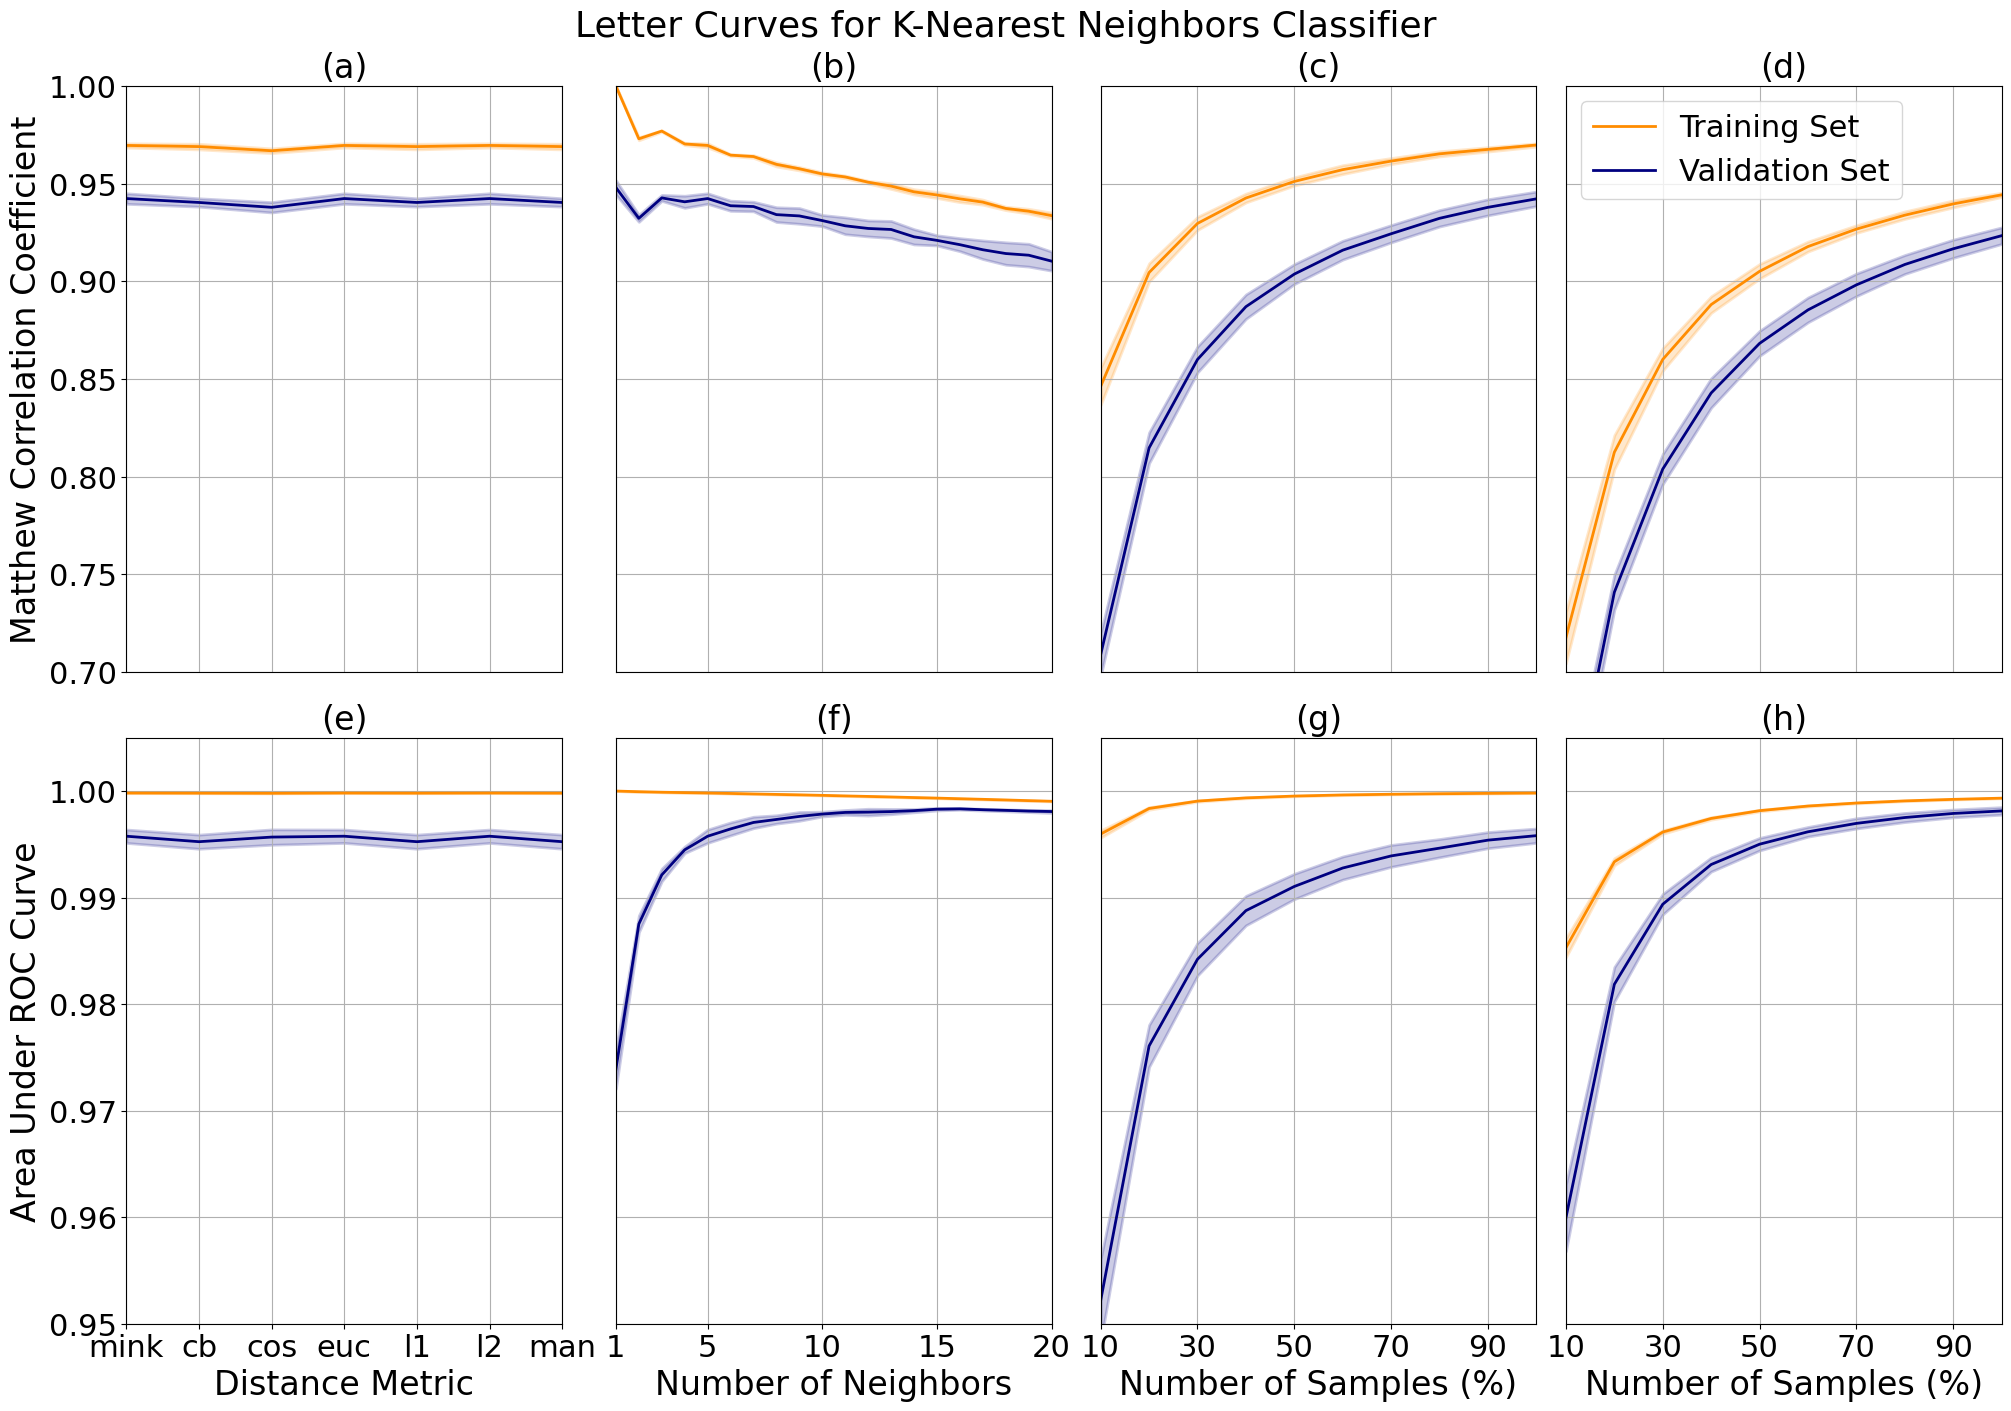

In [41]:
plt.show()
#plt.savefig('knn_letter.png',dpi=200)

# Support Vector Machines

Modeled with sklearn.svm.[SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC).

## Bioresponse and Letter Validation Curve Modeling

In [32]:
# initialize plot
plt.ioff()
fig, axs = plt.subplots(2, 4, constrained_layout=True)
fig.set_size_inches(20,14)

# kernel type
svm_kernel_name=['Kernel Type', 'kernel']
svm_kernel_range=['linear', 'poly', 'rbf', 'sigmoid']

svm_bio_kernel = plot_validation_curve(svm.SVC(random_state=42), bio_train_x, bio_train_y, sql_table='svm_bio', conn=conn, param_name=svm_kernel_name, param_range=svm_kernel_range, scoring=precision_scoring, read_db=True, ax=axs[0,0])
svm_letter_kernel = plot_validation_curve(svm.SVC(random_state=42), letter_train_x, letter_train_y, sql_table='svm_letter', conn=conn, param_name=svm_kernel_name, param_range=svm_kernel_range, scoring=mcc_scoring, read_db=True, ax=axs[1,0])

# coefficient 0
svm_c0_name=['Coef0', 'coef0']
svm_c0_range=[0.1,0.25,0.5,0.75,1,2,3,4,5,6,7,8,9,10]

svm_bio_c0 = plot_validation_curve(svm.SVC(random_state=42,kernel='poly'), bio_train_x, bio_train_y, sql_table='svm_bio', conn=conn, param_name=svm_c0_name, param_range=svm_c0_range, scoring=precision_scoring, read_db=True, ax=axs[0,1])
svm_letter_c0 = plot_validation_curve(svm.SVC(random_state=42, kernel='poly'), letter_train_x, letter_train_y, sql_table='svm_letter', conn=conn, param_name=svm_c0_name, param_range=svm_c0_range, scoring=mcc_scoring, read_db=True,  ax=axs[1,1])

# C
svm_c_name=['C', 'C']
svm_c_range=[0.1,0.5,0.75,1,1.25,1.5,2,3,4,5]

svm_bio_c = plot_validation_curve(svm.SVC(random_state=42,kernel='poly'), bio_train_x, bio_train_y, sql_table='svm_bio', conn=conn, param_name=svm_c_name, param_range=svm_c_range, scoring=precision_scoring, read_db=True, ax=axs[0,2])
svm_letter_c = plot_validation_curve(svm.SVC(random_state=42, kernel='poly'), letter_train_x, letter_train_y, sql_table='svm_letter', conn=conn, param_name=svm_c_name, param_range=svm_c_range, scoring=mcc_scoring, read_db=True, ax=axs[1,2])

# degree
svm_dg_name=['Degree', 'degree']
svm_dg_range=range(0,5)

svm_bio_dg = plot_validation_curve(svm.SVC(random_state=42,kernel='poly'), bio_train_x, bio_train_y, sql_table='svm_bio', conn=conn, param_name=svm_dg_name, param_range=svm_dg_range, scoring=precision_scoring, read_db=True, ax=axs[0,3])
svm_letter_dg = plot_validation_curve(svm.SVC(random_state=42, kernel='poly'), letter_train_x, letter_train_y, sql_table='svm_letter', conn=conn, param_name=svm_dg_name, param_range=svm_dg_range, scoring=mcc_scoring, read_db=True, ax=axs[1,3])

## Bioresponse and Letter Validation Curve Plots

Support vector machine validation curves while varying kernel type, kernel coefficient 0, C and degree for bioresponse data at (a, b, c, d) and letter data (e, f, g, h).

In [33]:
# titles
fig.suptitle('Bioresponse and Letter Validation Curves for Support Vector Machine Classifier',fontsize=fs+4)
axs[0,0].set_title('(a)',fontsize=fs+2)
axs[0,1].set_title('(b)',fontsize=fs+2)
axs[0,2].set_title('(c)',fontsize=fs+2)
axs[0,3].set_title('(d)',fontsize=fs+2)
axs[1,0].set_title('(e)',fontsize=fs+2)
axs[1,1].set_title('(f)',fontsize=fs+2)
axs[1,2].set_title('(g)',fontsize=fs+2)
axs[1,3].set_title('(h)',fontsize=fs+2)

# x labels
#letter_axs[1,0].set_xticklabels(knn_metric_range_labels)
axs[0,0].set_xlabel(None)
axs[0,1].set_xlabel(None)
axs[0,2].set_xlabel(None)
axs[0,3].set_xlabel(None)

axs[0,1].set_xticks([0.1,2,4,6,8,10])
axs[0,1].set_xticklabels([0.1,2,4,6,8,10])
axs[1,1].set_xticks([0.1,2,4,6,8,10])
axs[1,1].set_xticklabels([0.1,2,4,6,8,10])
axs[0,2].set_xticks([0.1,1,2,3,4,5])
axs[0,2].set_xticklabels([0.1,1,2,3,4,5])
axs[1,2].set_xticks([0.1,1,2,3,4,5])
axs[1,2].set_xticklabels([0.1,1,2,3,4,5])
axs[0,3].set_xticks([0,1,2,3,4])
axs[1,3].set_xticks([0,1,2,3,4])

# y limits and labels
axs[0,0].set_ylabel('Precision', fontsize=fs+2)
axs[1,0].set_ylabel('Matthew Correlation Coefficient', fontsize=fs+2)
axs[0,0].tick_params(labelbottom=False, bottom=False)
axs[0,1].tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
axs[0,2].tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
axs[0,3].tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
axs[1,1].tick_params(labelleft=False, left=False)
axs[1,2].tick_params(labelleft=False, left=False)
axs[1,3].tick_params(labelleft=False, left=False)

axs[0,0].set_ylim(0.7, 1)
axs[0,1].set_ylim(0.7, 1)
axs[0,2].set_ylim(0.7, 1)
axs[0,3].set_ylim(0.7, 1)
axs[1,0].set_ylim(0.6, 1)
axs[1,1].set_ylim(0.6, 1)
axs[1,2].set_ylim(0.6, 1)
axs[1,3].set_ylim(0.6, 1)

# legend
axs[0,3].legend(loc="best", fontsize=fs)

### Analysis

We were unable to analyze class distinction for this model as it is not supported by the sklearn package. The bioresponse and letter data showed similar responses for kernel type (a and e), with highest performance using a polynomial kernel. This is expected because they are not linearly separable due to the previously described complexity of each data set, but the increased performance comes at the cost of overfitting, which we can see from the gap between the training and validation curves. We attempted the radial basis function kernel to reduce variance, but opted for the polynomial kernel in our final models due to time considerations where the radial basis function ran roughly three times as long.

The degree controls the flexibility of the decision boundary and increases with performance for both problems. Our bioresponse data has a more complex boundary line which causes the model to overfit the data more with the increase of this parameter (d), as compared to the letter data (h) which doesn't show significant overfitting until after a degree of 3. Similarly, we see increased performance with increased variance while increasing the parameter C, which controls the size of the desired margin (b and f). As the margin decreases, the model is left with more room to overfit the data set.

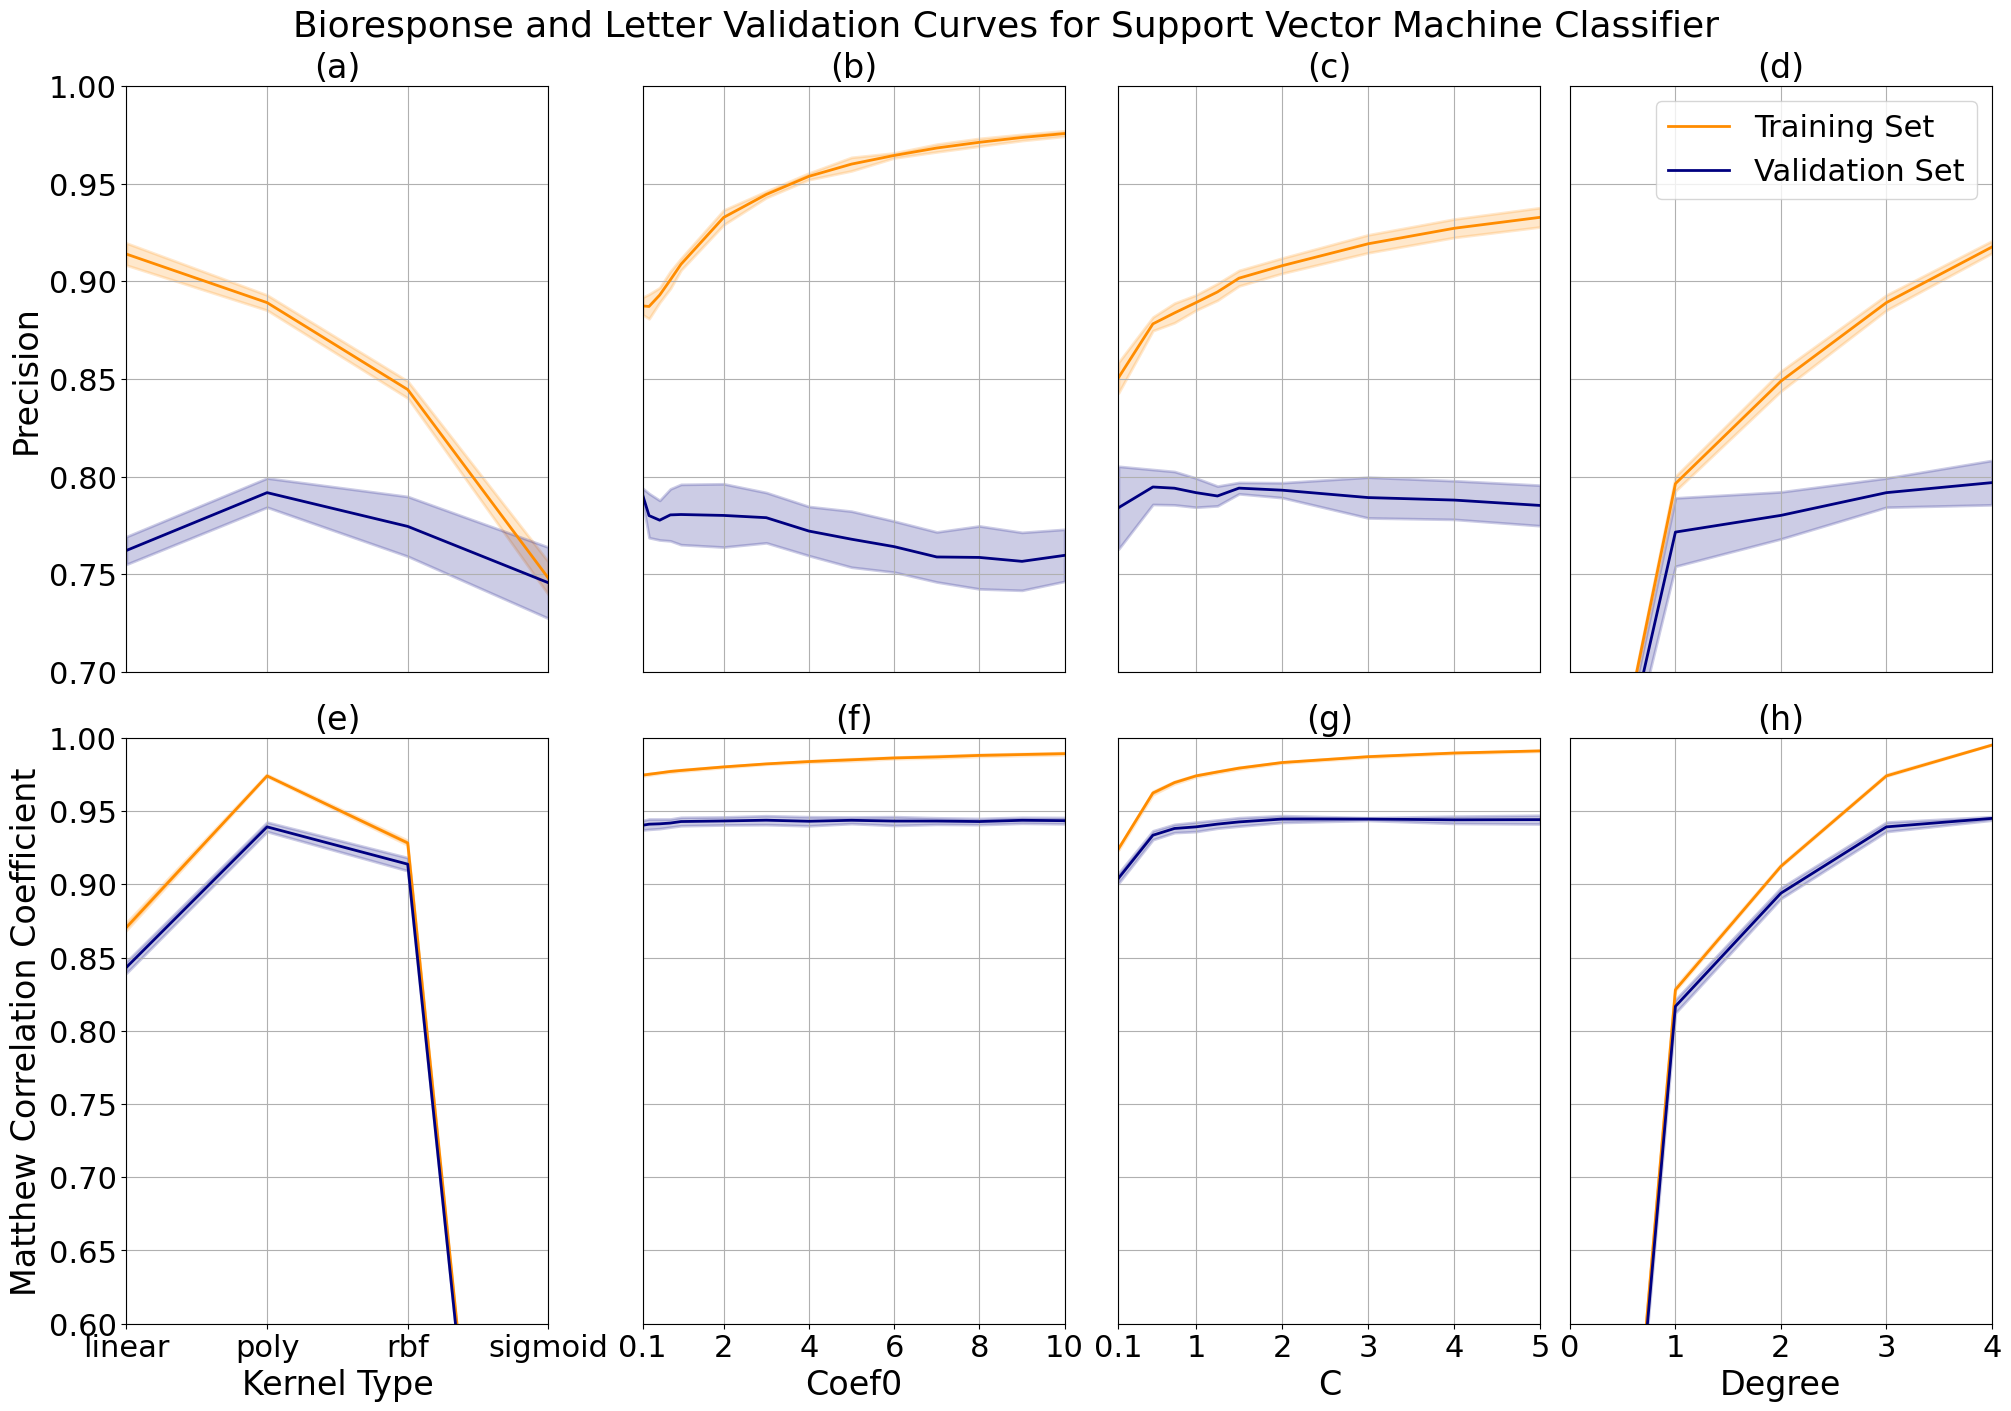

In [34]:
# save or plot
plt.show()
#plt.savefig('svm_vc.png',dpi=200)

## Bioresponse and Letter Learning Curve Modeling

In [36]:
# initialize plot
plt.ioff()
fig, axs = plt.subplots(1, 4, constrained_layout=True)
fig.set_size_inches(20,6)

# bio learning curves
svm_bio_lc = plot_learning_curve(svm.SVC(random_state=42, kernel='poly', coef0=0.1, C=4, degree=1), bio_train_x, bio_train_y, sql_table='svm_bio', conn=conn, scoring=precision_scoring, read_db=True, ax=axs[0])
svm_bio_lc_tuned = plot_learning_curve(svm.SVC(random_state=42, kernel='poly', coef0=0.1, C=0.5, degree=1), bio_train_x, bio_train_y, sql_table='svm_bio_tuned', conn=conn, scoring=precision_scoring, read_db=True, ax=axs[1])

# letter learning curves
svm_letter_lc = plot_learning_curve(svm.SVC(random_state=42, kernel='poly', C=0.5,degree=4), letter_train_x, letter_train_y, sql_table='svm_letter', conn=conn, scoring=mcc_scoring, read_db=True, ax=axs[2])
svm_letter_lc_tuned = plot_learning_curve(svm.SVC(random_state=42, kernel='poly', C=0.5,degree=2), letter_train_x, letter_train_y, sql_table='svm_letter_tuned', conn=conn, read_db=True, scoring=mcc_scoring, ax=axs[3])

## Bioresponse and Letter Learning Curve Plots

Support vector machine learning curves for bioresponse data at C 4 (a) and 0.5 (b) and letter data  at degree 4 (c) and 2 (d).

In [37]:
# title and subplot titles
fig.suptitle('Learning Curves for Support Vector Machine Classifier',fontsize=fs+4)
axs[0].set_title('(a)',fontsize=fs+2)
axs[1].set_title('(b)',fontsize=fs+2)
axs[2].set_title('(c)',fontsize=fs+2)
axs[3].set_title('(d)',fontsize=fs+2)

# x labels
axs[0].set_xticks([240,  480,  960, 1440, 1920, 2400])
axs[0].set_xlim(240, 2400)
axs[1].set_xticks([240,  480,  960, 1440, 1920, 2400])
axs[1].set_xlim(240, 2400)
axs[2].set_xticks([ 1280, 3840,  6400, 8960, 11520])
axs[2].set_xlim(1280, 12800)
axs[3].set_xticks([ 1280, 3840,  6400, 8960, 11520])
axs[3].set_xlim(1280, 12800)

# y limits and labels
axs[0].set_ylabel('Precision', fontsize=fs+2)
axs[1].tick_params(labelleft=False, left=False)
axs[0].set_ylim(0.6, 1)
axs[1].set_ylim(0.6, 1)
axs[2].set_ylabel('Matthew Correlation Coefficient', fontsize=fs+2)
axs[3].tick_params(labelleft=False, left=False)
axs[2].set_ylim(0.75, 1)
axs[3].set_ylim(0.75, 1)

# legend
axs[1].legend(loc="best", fontsize=fs)
axs[3].legend(loc="best", fontsize=fs)

### Analysis

We took a closer look at the validation curve responses by generating learning curves while varying C for the bioresponse data from 4 (a) to 0.5 (b) and degree for the letter data from 4 (c) to 2 (d). For the bioresponse data we observed a decrease in the precision of the training curve which more closely tracks the shape of the validation curve, verifying that there is a reduction in variance. The training curve however trends downward, limiting the possibility of an increase in precision with additional data. We see a reduction in variance for the letter data as well, but at the cost of increased bias. The upwards trend of both curves imply that the model may improve with further tuning and additional samples.

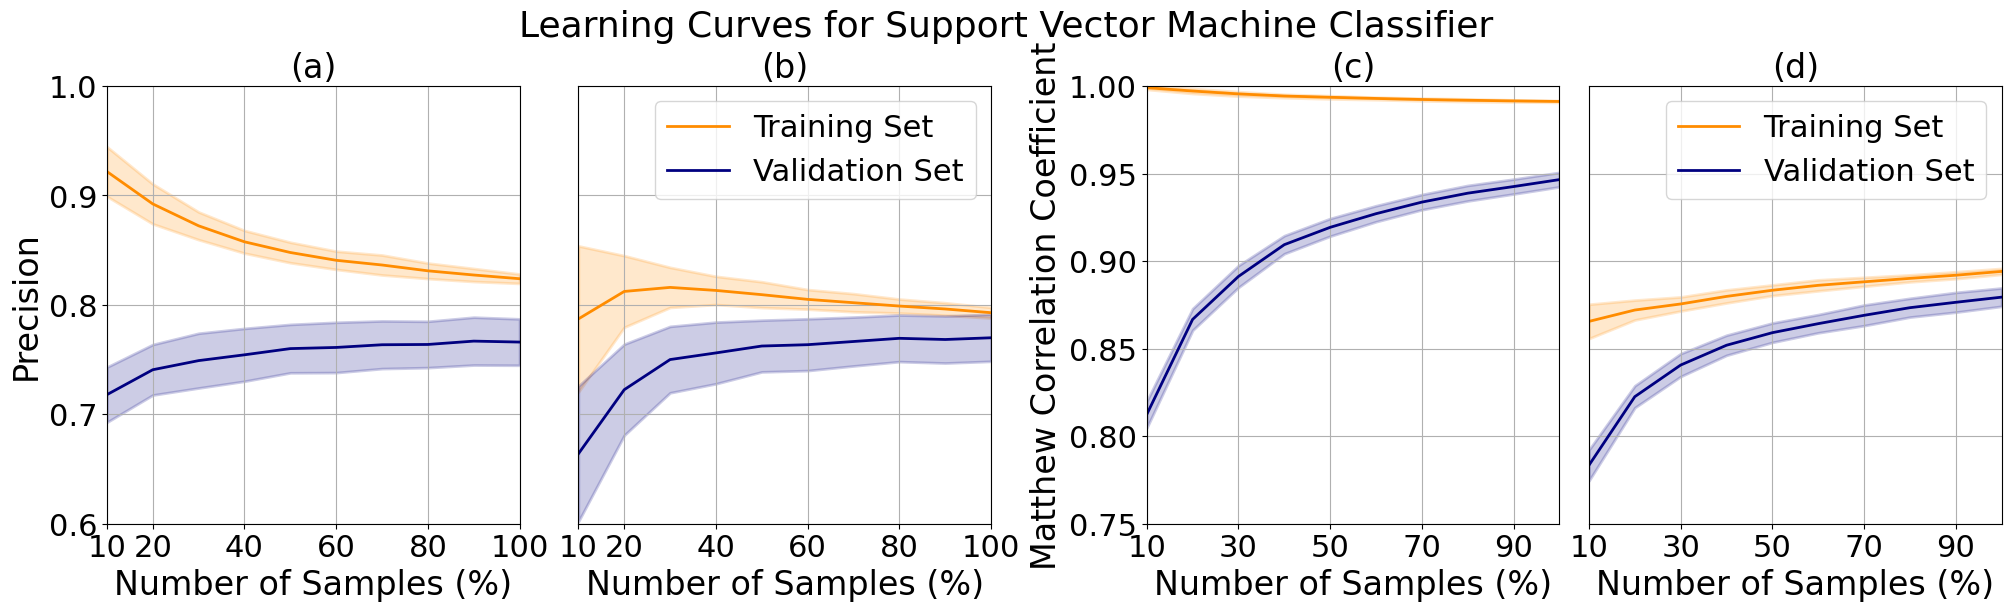

In [38]:
# save or plot
plt.show()
#plt.savefig('svm_lc.png',dpi=200)

# Neural Nets

Modeled using sklearn.neural_network.[MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

## Validation and Learning Curve Modeling

In [66]:
# initialize plot
plt.ioff()
fig, axs = plt.subplots(2, 4, constrained_layout=True)
fig.set_size_inches(20, 14)

# hidden layer sizes
nn_hl_name=['First Layer Width', 'hidden_layer_sizes']
nn_hl_range=[3, 5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100]

nn_bio_hl = plot_validation_curve(MLPClassifier(random_state=42,max_iter=2000,early_stopping=True),
                                      bio_train_x, bio_train_y, sql_table='nn_bio', conn=conn, param_name = nn_hl_name, param_range =nn_hl_range, scoring = precision_scoring, read_db=True, ax=axs[0,0])

nn_letter_hl = plot_validation_curve(MLPClassifier(random_state=42,max_iter=2000,early_stopping=True),
                                     letter_train_x, letter_train_y, sql_table='nn_letter', conn=conn, param_name=nn_hl_name, param_range=nn_hl_range, scoring=mcc_scoring, read_db=True, ax=axs[1,0])

# activation function
nn_af_name=['Activation Function', 'activation']
nn_af_range=['identity', 'logistic', 'tanh', 'relu']

nn_bio_af = plot_validation_curve(MLPClassifier(random_state=42,max_iter=2000,early_stopping=True),
                                  bio_train_x, bio_train_y, sql_table='nn_bio', conn=conn, param_name=nn_af_name, param_range=nn_af_range, scoring=precision_scoring, read_db=True, ax=axs[0,1])

nn_letter_af = plot_validation_curve(MLPClassifier(random_state=42,max_iter=2000,early_stopping=True),
                                     letter_train_x, letter_train_y, sql_table='nn_letter', conn=conn, param_name=nn_af_name, param_range=nn_af_range, scoring=mcc_scoring, read_db=True, ax=axs[1,1])

# solver
nn_solver_name=['Solver', 'solver']
nn_solver_range=['lbfgs', 'sgd', 'adam']

nn_bio_solver = plot_validation_curve(MLPClassifier(random_state=42,max_iter=2000,early_stopping=True),
                                      bio_train_x, bio_train_y, sql_table='nn_bio', conn=conn, param_name=nn_solver_name, param_range=nn_solver_range, scoring=precision_scoring, read_db=True, ax=axs[0,2])
nn_letter_solver = plot_validation_curve(MLPClassifier(random_state=42,max_iter=2000,early_stopping=True),
                                         letter_train_x, letter_train_y, sql_table='nn_letter', conn=conn, param_name=nn_solver_name, param_range=nn_solver_range, scoring=mcc_scoring, read_db=True, ax=axs[1,2])

# learning curves
nn_bio_lc = plot_learning_curve(MLPClassifier(random_state=42,max_iter=2000,early_stopping=True, solver='sgd', activation='relu', hidden_layer_sizes=(80,)), 
                                bio_train_x, bio_train_y, sql_table='nn_bio_tuned', conn=conn, scoring=precision_scoring, read_db=True, ax=axs[0,3])
nn_letter_lc = plot_learning_curve(MLPClassifier(random_state=42,max_iter=2000,early_stopping=True, solver='adam', activation='tanh', hidden_layer_sizes=(100,)),  
                                letter_train_x, letter_train_y, sql_table='nn_letter_tuned', conn=conn, scoring=mcc_scoring, read_db=True, ax=axs[1,3])

### Validation and Learning Curve Plots

Neural network validation curves for bioresponse and letter data while varying the first hidden layer width (a, e), activation function (b, f), solver (c, g). Learning curves for bioresponse (d) and letter data (h) after tuning.

In [67]:
# titles
fig.suptitle('Bioresponse and Letter Validation and Learning Curves for Neural Network Classifier',fontsize=fs+4)
axs[0,0].set_title('(a)',fontsize=fs+2)
axs[0,1].set_title('(b)',fontsize=fs+2)
axs[0,2].set_title('(c)',fontsize=fs+2)
axs[0,3].set_title('(d)',fontsize=fs+2)
axs[1,0].set_title('(e)',fontsize=fs+2)
axs[1,1].set_title('(f)',fontsize=fs+2)
axs[1,2].set_title('(g)',fontsize=fs+2)
axs[1,3].set_title('(h)',fontsize=fs+2)

# x labels
axs[0,0].set_xlabel(None)
axs[0,1].set_xlabel(None)
axs[0,2].set_xlabel(None)
axs[0,3].set_xlabel(None)

axs[0,3].set_xticks([240,  480,  960, 1440, 1920, 2400])
axs[0,3].set_xlim(240, 2400)
axs[1,3].set_xticks([ 1280, 3840,  6400, 8960, 11520])
axs[1,3].set_xlim(1280, 12800)

# y limits and labels
axs[0,0].set_ylabel('Precision', fontsize=fs+2)#
axs[1,0].set_ylabel('Matthew Correlation Coefficient', fontsize=fs+2)
axs[0,0].tick_params(labelbottom=False, bottom=False)
axs[0,1].tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
axs[0,2].tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
axs[0,3].tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
axs[1,1].tick_params(labelleft=False, left=False)
axs[1,2].tick_params(labelleft=False, left=False)
axs[1,3].tick_params(labelleft=False, left=False)

axs[0,0].set_ylim(0.6, 1)
axs[0,1].set_ylim(0.6, 1)
axs[0,2].set_ylim(0.6, 1)
axs[0,3].set_ylim(0.6, 1)
axs[1,0].set_ylim(0.6, 1)
axs[1,1].set_ylim(0.6, 1)
axs[1,2].set_ylim(0.6, 1)
axs[1,3].set_ylim(0.6, 1)

# legend
axs[0,3].legend(loc="best", fontsize=fs)

### Analysis

The data sets were not large enough to elicit any changes in performance with multiple layers, so we looked at variations in the width of a single hidden layer. The bioresponse data precision increased marginally with layer width at the cost of increasing complexity, due to the relatively small length of the dataset, and therefore to limit model overfitting we tuned our final model to a width of 80. We see an expected significant increase in performance with respect to width for the letter data, which contains roughly 6 times the amount of records. The model performance increases further as additional width is added to the layer, at the cost of significant time increases due to the backpropogation of the model. To reduce time complexity, we limited the layer to a width of 100 units.

We can see that the highest performing activation function for our bioresponse data is ReLU, a function known to minimize the vanishing gradient effect which may be an indication that this is more prevalent in data sets with a large number of features, as compared to the letter data which performed best with a Tanh function. The best performing solver for both data sets was adam, a modernized form of stochastic gradient descent, which came at a large increase in variance for the bioresponse data. Because of this, we chose to use stochastic gradient descent or 'sgd' for our final model. 

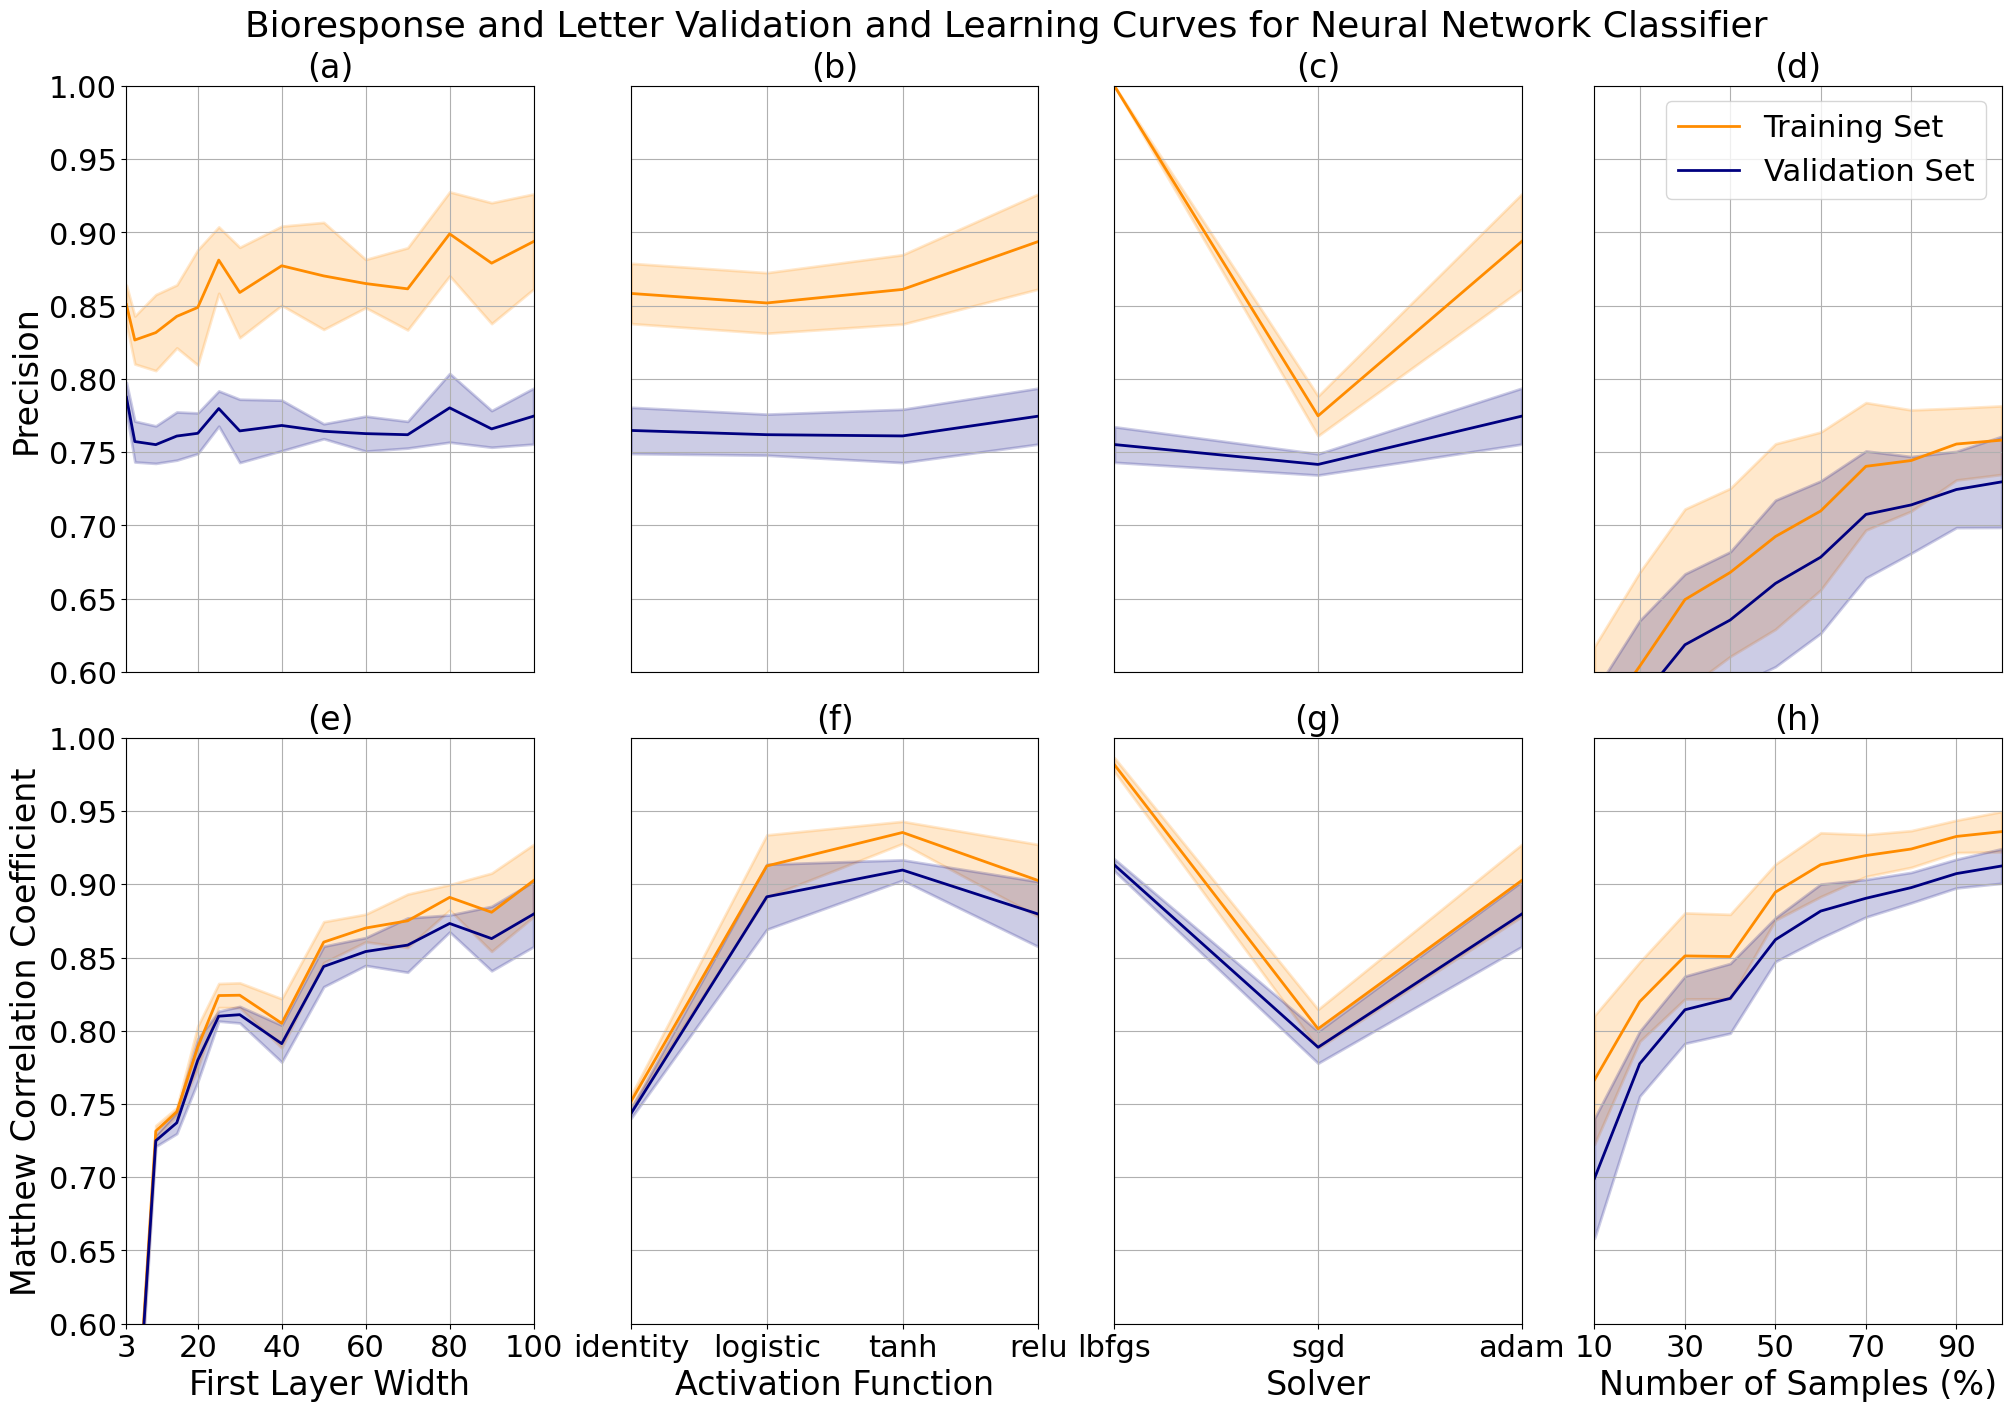

In [68]:
# plot or save
plt.show()
#plt.savefig('nn_vclc.png',dpi=200)

## Loss Curves

Loss curves for bioresponse data (left) and letter data (right).

In [69]:
read_db = True
if not read_db:
    # fit best bio neural network classifier
    nn_bio_best = MLPClassifier(random_state=42,max_iter=2000,early_stopping=True, solver='adam', activation='tanh', hidden_layer_sizes=(100,))
    nn_bio_best.fit(bio_train_x, bio_train_y)

    # calculate loss per iteration
    nn_bio_loss = nn_bio_best.loss_curve_
    pd.DataFrame(nn_bio_loss).to_sql(f'nn_bio_loss', conn, if_exists="replace", index=False)

    # fit best letter neural network classifier
    nn_letter_best = MLPClassifier(random_state=42,max_iter=2000,early_stopping=True, solver='adam', activation='tanh', hidden_layer_sizes=(100,))
    nn_letter_best.fit(letter_train_x, letter_train_y)

    # calculate loss per iteration
    nn_letter_loss = nn_letter_best.loss_curve_
    pd.DataFrame(nn_bio_loss).to_sql(f'nn_letter_loss', conn, if_exists="replace", index=False)
    
nn_bio_loss = pd.read_sql_query(f"SELECT * FROM 'nn_bio_loss'", conn)
nn_bio_loss_iterations = range(1,len(nn_bio_loss)+1)
nn_letter_loss = pd.read_sql_query(f"SELECT * FROM 'nn_letter_loss'", conn)
nn_letter_loss_iterations = range(1,len(nn_letter_loss)+1)

In [76]:
# initialize plot
plt.ioff()
fig, axs = plt.subplots(1, 2, constrained_layout=True)
fig.set_size_inches(16, 10)
fig.suptitle('Loss Curves for Neural Network Classifier',fontsize=fs+4)

# plot bio loss
axs[0].plot(nn_bio_loss_iterations, nn_bio_loss, color='darkorange', lw=2)
axs[0].set_xlabel('Iterations', fontsize=24)
axs[0].set_xlim(1,max(nn_bio_loss_iterations))
axs[0].set_ylabel('Loss', fontsize=fs+2)
axs[0].tick_params(labelsize=fs)
axs[0].grid()
axs[0].set_title('Bioresponse', fontsize=fs+4)

# plot letter loss
axs[1].plot(nn_letter_loss_iterations, nn_letter_loss, color='darkorange', lw=2)
axs[1].set_xlabel('Iterations', fontsize=fs+2)
axs[1].set_xlim(1,max(nn_letter_loss_iterations))
axs[1].set_ylabel('Loss', fontsize=fs+2)
axs[1].tick_params(labelsize=fs)
axs[1].grid()
axs[1].set_title('Letter', fontsize=fs+4)


Text(0.5, 1.0, 'Letter')

### Analysis

The loss curves for our neural networks show that both models are optimally tuned, as we can see minimal oscillation on either curve.

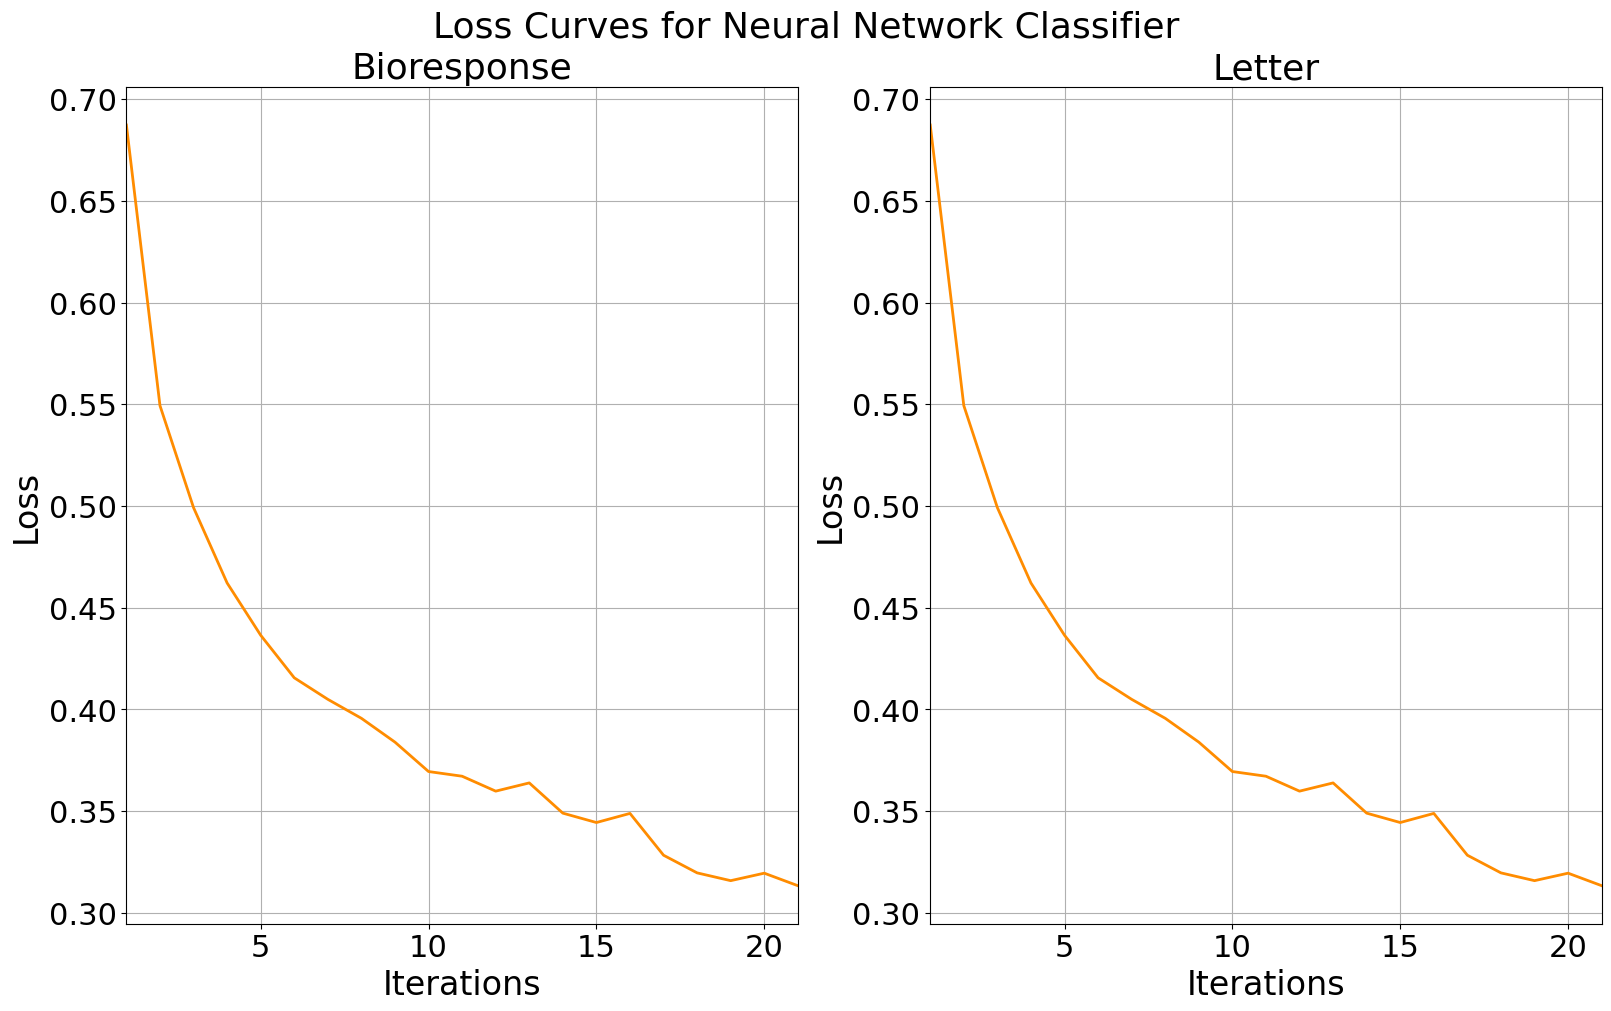

In [77]:
# plot or save
plt.show()
#plt.savefig('nn_loss.png',dpi=200)